## Load libraries
The preprocessed COCO datasets and libraries are loaded.<br>

In [1]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook

data = load_coco_data(base_dir=data_path)
if len(data)==8 : 
    print('COCO data load complete')
   
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

COCO data load complete
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
features <class 'numpy.ndarray'> (82783, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
urls <class 'numpy.ndarray'> (82783,) <U63
val_captions <class 'numpy.ndarray'> (10000, 17) int32
val_image_idxs <class 'numpy.ndarray'> (10000,) int32


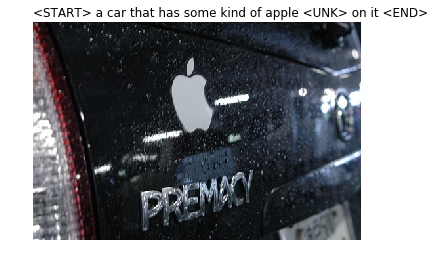

In [3]:
# Sample images and captions
captions, features, urls = sample_coco_minibatch(data, batch_size=1)
show_samples(captions, urls, data)

## Data for training

For simple test, you can load subsample of total train data.<br>
But you should use <font color=red>**full train_data**</font> for final test.<br>
You will be able to verify your captioning model more quickly with the small train data.<br>
<font color=red>**You must show loss changes with full train data**</font> when you train. <br>
And you must show maxlen, n_words, captions.shape.


In [4]:
#-------------------------------------------------------------------------
# CAUTION: Do not change maxlen(17), n_words(1004), input_dimension(512)
# you should use 512 extracted image features
# Do not change coco_utils.py
#-------------------------------------------------------------------------

#----------------------------------------------
# [case 1] subsample
# Try to subsamples of train_data for simple test
#----------------------------------------------
#train_data = load_coco_data(base_dir=data_path, max_train=500)

#----------------------------------------------
# [case 2] full train data
# Try to full train_data for real test
#----------------------------------------------
train_data = data

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]
input_dimension = train_data['features'].shape[1]


print(n_words)
print(maxlen)
print(img_features.shape, captions.shape)

vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]
print(vimg_features.shape, vcaptions.shape)


1004
17
(400135, 512) (400135, 17)
(10000, 512) (10000, 17)


In [5]:
#################################################################################
# TODO: Implement for caption training class in captioning.py
# you should use TensorFlow RNN libraries (such as tf.contrib.rnn)
# You can modify classes, functions, parameters according to your model structure.
# You can also hide the train function in the Captioning class.
# Just show the loss changes depending on the learning procedure.
#
# class Captioning():
#     def __init(self,...):
#     def model(self,...):
#     def predict(self,...):
#################################################################################
# for sample training
#captioning = Captioning(128,is_training=True)
# for full training
captioning = Captioning(2000,is_training=True)
captioning.build_model()
captioning.train(img_features, captions)

print(captioning.maxlen, captioning.n_words, captions.shape)


Total EPOCH: 150
LOCAL EPOCH : 0, LOSS: 4.5079
LOCAL EPOCH : 5, LOSS: 3.2210
LOCAL EPOCH : 10, LOSS: 2.7864
LOCAL EPOCH : 15, LOSS: 2.6125
LOCAL EPOCH : 20, LOSS: 2.5187
LOCAL EPOCH : 25, LOSS: 2.4585
LOCAL EPOCH : 30, LOSS: 2.4071
LOCAL EPOCH : 35, LOSS: 2.3684
LOCAL EPOCH : 40, LOSS: 2.3361
LOCAL EPOCH : 45, LOSS: 2.3145
LOCAL EPOCH : 50, LOSS: 2.2899
LOCAL EPOCH : 55, LOSS: 2.2692
LOCAL EPOCH : 60, LOSS: 2.2558
LOCAL EPOCH : 65, LOSS: 2.2480
LOCAL EPOCH : 70, LOSS: 2.2299
LOCAL EPOCH : 75, LOSS: 2.2221
LOCAL EPOCH : 80, LOSS: 2.2108
LOCAL EPOCH : 85, LOSS: 2.1967
LOCAL EPOCH : 90, LOSS: 2.1849
LOCAL EPOCH : 95, LOSS: 2.1793
LOCAL EPOCH : 100, LOSS: 2.1687
LOCAL EPOCH : 105, LOSS: 2.1628
LOCAL EPOCH : 110, LOSS: 2.1541
LOCAL EPOCH : 115, LOSS: 2.1486
LOCAL EPOCH : 120, LOSS: 2.1408
LOCAL EPOCH : 125, LOSS: 2.1342
LOCAL EPOCH : 130, LOSS: 2.1276
LOCAL EPOCH : 135, LOSS: 2.1292
LOCAL EPOCH : 140, LOSS: 2.1233
LOCAL EPOCH : 145, LOSS: 2.1197
Training done!
17 1004 (400135, 17)


## Evaluation

You can test your model in train, validation samples with sample images.<br>
Final evaluation will be done with average BLEU score.<br>
BLEU (bilingual evaluation understudy) score is between 0 and 1. The values closer to 1 represents more similar texts. <br>
https://en.wikipedia.org/wiki/BLEU
<font color=red>**Your model could be evaluated without traning procedure,**</font> if you saved and loaded your model properly.


In [6]:
import tensorflow as tf
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd

import tensorflow.python.platform

from coco_utils import *
from captioning import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_path='./models_captioning'
data_path ='./coco/coco_captioning'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

train_data = load_coco_data()

captions = train_data['train_captions']
img_idx  = train_data['train_image_idxs']
img_features = train_data['features'][img_idx]
word_to_idx = train_data['word_to_idx']
idx_to_word = train_data['idx_to_word']
vcaptions = train_data['val_captions']
vimg_idx  = train_data['val_image_idxs']
vimg_features = train_data['features'][vimg_idx]

n_words = len(word_to_idx)
maxlen = train_data['train_captions'].shape[1]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Write your code for image captioning predicting
# The image_captioning should include following functions
# - load your saved model 
# - return predicted captions from image features

def image_captioning(features) :
    pr_captions = np.zeros((features.shape[0],maxlen),int)
    #################################################
    # TODO: Implement predicting image captioning
    # - load your saved model
    # - predict the captions
    #################################################
    tf.reset_default_graph()
    
    captioning=Captioning(2000,is_training=False)
    captioning.build_model()
            
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)), graph=captioning.graph) as sess:
    
        saver = tf.train.Saver()
        saver.restore(sess, "./models_captioning/captioning_model-30000")         
        pr_captions = captioning.prediction(sess, features, word_to_idx, idx_to_word)

    #################################################
    #                END OF YOUR CODE               #
    #################################################
    return pr_captions

INFO:tensorflow:Restoring parameters from ./models_captioning/captioning_model-30000


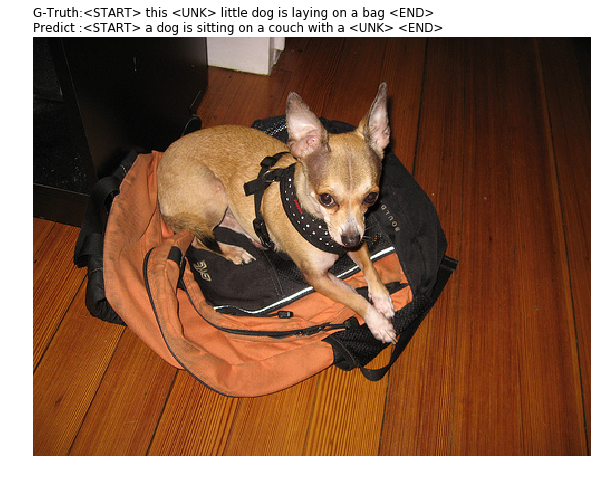

INFO:tensorflow:Restoring parameters from ./models_captioning/captioning_model-30000


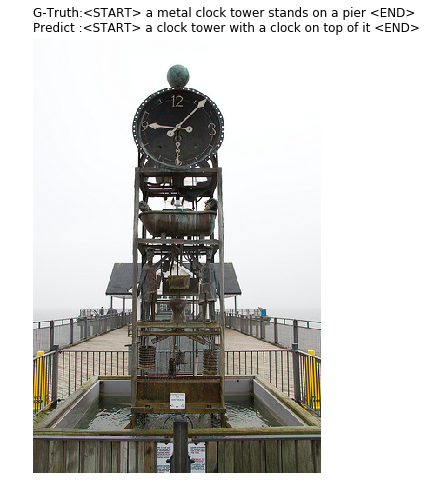

In [8]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(train_data, split=split, batch_size=1)

    gt_captions, features, urls = minibatch
    pr_captions = image_captioning(features)

    show_predict_samples(gt_captions, pr_captions, urls, train_data)

In [9]:
# Prints unigram BLEU score averaged over val dataset

def evaluate_model(data, split):
    BLEUscores = {}

    minibatch = sample_coco_minibatch(data, split=split, batch_size="All")
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    pr_captions = image_captioning(features)
    pr_captions = decode_captions(pr_captions, data['idx_to_word'])

    total_score = 0.0
        
    for gt_caption, pr_caption, url in zip(gt_captions, pr_captions, urls):
        total_score += BLEU_score(gt_caption, pr_caption)

    BLEUscores[split] = total_score / len(pr_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))


In [10]:
evaluate_model(train_data,'val')

Total captions: 10000
INFO:tensorflow:Restoring parameters from ./models_captioning/captioning_model-30000
Average BLEU score for val: 0.327939


In [ ]:
# This cell is for TA, TA will evaluate your model with independent test_data
# the number of captions of test_data is about 200,000
# you should handle captions up to 200,000

#evaluate_model(test_data,'test')



## Describe what you did here
In this cell you should also write an explanation of what you did.<br>
(A detailed description of your model, structure, tensorflow module and others)
<font color=red>**You must describe your model**</font>

## Model:
* training_epoch  : 150
* the number of hidden state: 512
* embedding size: 512
 => the word is embedded by embedding size 512.
* "teacher forcing" used
* cross entropy loss used
* Adam optimizer and decay by global step used
* loss is computed by compare each of the word embedding's inputs and outputs

## tensorflow module:
* 'Captioning' object has 4 methods including the initializer.
* this object's batch_size can be adjusted using the method "init()"'s parameter.
* the method 'build_model' builds the model
* and it can be used in both the training mode and the testing mode
* by injecting the argument 'is_training' into the initiater.
* the method "train" trains the model
* and the method "prediction" predicts the image featrues and output the captions.
* But the method "prediction" is too slow to predict because it uses only one size of the image features at once.

## Train Usage Example:
```python
    from captioning import *
    captioning = Captioning(batch_size,is_training=True)
    captioning.build_model()
    captioning.train(img_features, captions) 
```
## RNN implementation
```python
    self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units = self.n_hidden, state_is_tuple = True);

    if self.is_training is True:
        self.lstm_cell = tf.contrib.rnn.DropoutWrapper(self.lstm_cell,
                                                input_keep_prob=0.7, output_keep_prob=0.7)

    with tf.variable_scope('lstm', initializer=self.initializer) as lstm_scope:
        self.zero_state = self.lstm_cell.zero_state(batch_size = self.batch_size, dtype = tf.float32)
        _, self.initial_state = self.lstm_cell(self.image_embeddings, self.zero_state)
        lstm_scope.reuse_variables()

        if self.is_training is True:
            seq_len = tf.reduce_sum(self.input_mask, 1)
            lstm_output, state = tf.nn.dynamic_rnn(cell = self.lstm_cell,
                                               inputs = self.seq_embeddings,
                                               sequence_length = seq_len,
                                               initial_state = self.initial_state,
                                               dtype = tf.float32,
                                               scope = lstm_scope)

```                                        
* Use Dropout when training the model
* Use dynamic_rnn when training the model, it implies "teacher forcing" method
* "self.input_mask" is used to select the word really used to the captions.

## PREDICTION
```python
    initial_state = sess.run(self.initial_state, feed_dict={self.img_features: img_feature[e: e+1]})
    
    word = word_to_idx["<START>"]

    word, state = sess.run([self.predict, self.state_tuple],
                                           feed_dict={
                                               self.state_feed: state,
                                               self.input_seqs: np.array([[word]])})
```                                      
* the initial_state's input is image features which have 512-dimension.
* start word is START and we prdict the next word using the output word.

## Average BLEU score for val: 0.327939